# A/B Testing Use Case

A software company sells a product which has a 7-day trial period; they expect that the trial testers are likelier to buy the software. They want to experiment which web layout leads to more trial testers, i.e., the structure and the content should invite to join to the 7-day trial period.

Steps:

1. Design funnel and metrics to track
2. Estimate experiment size/duration
3. Statistical analysis of the data
4. Conclusion: which layout is necessary?


## 1. Funnel and Metrics

Expected, normal flow:

- Visit homepage
- Visit download page
- Sign up for an account
- Download software
- After the 7-day trial, the software takes the user to a license-purchase page
- Purchase license

Atypical events:

- Users land in the 7-day trial page from somewhere else
- Users buy the license before 7 days
- Users buy the license after 7 days

We need to choose:

- Where to split users into experimental groups: the unit of diversion
- Which metrics to track in each step, both invariant and evaluation metrics

Diversion methods:

- Event-based, i.e., page view: not good here, because if the visitor gets a different view every time he/she opens the page, that's disturbing.
- User-ID, i.e., account: not good here, because some users sign in when hitting the download button.
- Cookie-based: best choice here; however, typical issues of cookies hold: what if the user accesses via incognito browsing? We assume those issues are insignificant.

Metrics:

- Number of users at each stage of the funnel/flow.
    - Invariant metric: Total number of cookies
- Number of licenses bought?
    - Evaluation metric: download rate
    - Evaluation metric: purchase rate
- Is it possible to track software usage statistics?


## 2. Experiment Sizing

- Invariant metric: 3250 unique visitors/day
    - Slightly more on weekdays
- Evaluation metric 1: 520 downloads/day: 0.16
- Evaluation metric 2: 65 license purchases/day: 0.02

If any evaluation metric 1 / 2 increases significantly, the experiment is successful, i.e., we should deploy the layout that favors the increase. Even in that case we need to apply the Bonferroni correction:

`alpha = 0.05 / 2 = 0.025`

**However, if we needed to see an increase in both metrics, we wouldn't need to apply Bonferroni - WTF!?**

### Questions

> 1. Let's say that we want to detect an increase of 50 downloads per day (up to 570 per day, or a .175 rate). How many days of data would we need to collect in order to get enough visitors to detect this new rate at an overall 5% Type I error rate and at 80% power?

Using the `experiment_size()` function from the notebook [L2_Experiment_Size_Solution.ipynb](./L2_Experiment_Size_Solution.ipynb) introduced previously:

```python
experiment_size(p_null=0.16, p_alt=0.175, alpha=0.025, beta=0.2) / 3250
# 2.91 -> 3
```

> 2. What if we wanted to detect an increase of 10 license purchases per day (up to 75 per day, or a .023 rate). How many days of data would we need to collect in order to get enough visitors to detect this new rate at an overall 5% Type I error rate and at 80% power?

```python
experiment_size(p_null=0.02, p_alt=0.023, alpha=0.025, beta=0.2) / 3250
# 10.74 -> 11
```

The solution has values that are double the ones I got; that is maybe because the formula implementation is *pone-sided*, but the solution is *two-sided*?

However, **important note**: consider there is a delay between the implementation and the downloads; maybe the first week after implementation the downloads are due to the UX before the implementation. Thus, we should consider extending slightly the experiment.

## 3. Data Analysis

Dataset collected during 29 days (21 + 8 days): [`homepage-experiment-data.csv`](./data/homepage-experiment-data.csv).

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats.distributions as dist
import scipy.stats as stats

In [2]:
df = pd.read_csv("./data/homepage-experiment-data.csv")

In [3]:
df.head()

,Day,Control Cookies,Control Downloads,Control Licenses,Experiment Cookies,Experiment Downloads,Experiment Licenses
0,1,1764,246,1,1850,339,3
1,2,1541,234,2,1590,281,2
2,3,1457,240,1,1515,274,1
3,4,1587,224,1,1541,284,2
4,5,1606,253,2,1643,292,3


In [81]:
df.shape

(29, 7)

In [84]:
df.sum()

Day                       435
Control Cookies         46851
Control Downloads        7554
Control Licenses          710
Experiment Cookies      47346
Experiment Downloads     8548
Experiment Licenses       732
dtype: int64

### T-Test Function

In [12]:
def t_test(subset1, subset2):
    '''This function computes the Z Test of two population proportions.
    H0: The proportions are the same.
    Ha: The proportions are different (two-sided).

    Input:
        subset1: data frame with values to analyze for subset/group 1
        subset1: data frame with values to analyze for subset/group 2
    Output:
        t_stat: T statistic; if very negative, subset1 has a considerebly smaller mean
        p_value: if < 0.05, the difference is significant, the two distribution means are different
    '''
    
    # Sample sizes    
    n1 = subset1.shape[0]
    n2 = subset2.shape[0]
    
    # Means
    m1 = subset1.mean()
    m2 = subset2.mean()

    # Standard Deviations
    sd1 = subset1.std()
    sd2 = subset2.std()

    # Standard Error
    if sd1/sd2 < 2.0 or sd2/sd1 < 2.0:
        # Similar variances: Pooled
        se = np.sqrt(((sd1**2)/n1) + ((sd2**2)/n2))
    else:
        # Different variances: Unpooled
        se = np.sqrt(((n1-1)*sd1**2 + (n2-1)*sd2**2)/(n1+n2-2)) * np.sqrt((1/n1) + (1/n2))
    
    # T statistic
    t_stat = (m1 - m2)/se    
    # With T and df, we can get the p-value from the T distribution
    df = n1 + n2 - 2
    # p-value is obtained form the cummulative density function (CDF) with the given df
    # since we want the remaining are under the PDF, we need to compute 1-CDF(t)
    # Since it is a 2-sided test (Ha !=), we need to x2 the p-value
    p_value = 2*(1 - dist.t.cdf(np.abs(t_stat),df=df))
    
    return (t_stat, p_value, m1, m2)

### Z-Test Function

In [130]:
def z_test(p1, n1, p2, n2):
    '''This function computes the Z Test of two population proportions.
    H0: The proportions are the same.
    Ha: The proportions are different (two-sided).
    
    Input:
        p1: ratio of group 1
        n1: size of group 1
        p1: ratio of group 2
        n1: size of group 2
    Output:
        z_stat: Z statistic; if very negative, subset1 has a considerebly smaller proportion
        p_value: if < 0.05, the difference is significant, the two proportions are different
    '''    
    if p1 == p2:
        print('Warning: same proportions!')

    # Estimate of the combined population proportion
    phat = (p1*n1 + p2*n2) / (n1 + n2)
    
    # Estimate of the variance of the combined population proportion
    va = phat * (1 - phat)

    # Estimate of the standard error of the combined population proportion
    se = np.sqrt(va * ((1.0 / n1) + (1.0 / n2)))

    # Test statistic and its p-value: 2-sided, because the Ha is !=
    z_stat = (p1 - p2) / se
    p_value = 2*dist.norm.cdf(-np.abs(z_stat))
    # Equivalent to
    # p_value = 2*(1-dist.norm.cdf(np.abs(z_stat)))

    return (z_stat, p_value, p1, p2)

### Man-Whitnney

In [131]:
def ranked_sum(x, y, alternative = 'two-sided'):
    """
    Return a p-value for a ranked-sum test, assuming no ties.
    
    Input parameters:
        x: 1-D array-like of data for first group
        y: 1-D array-like of data for second group
        alternative: type of test to perform, {'two-sided', less', 'greater'}
    
    Output value:
        p: estimated p-value of test
    """
    
    # compute U
    u = 0
    for i in x:
        wins = (i > y).sum()
        ties = (i == y).sum()
        u += wins + 0.5 * ties
    
    # compute a z-score
    n_1 = x.shape[0]
    n_2 = y.shape[0]
    mean_u = n_1 * n_2 / 2
    sd_u = np.sqrt( n_1 * n_2 * (n_1 + n_2 + 1) / 12 )
    z = (u - mean_u) / sd_u
    
    # compute a p-value
    if alternative == 'two-sided':
        p = 2 * stats.norm.cdf(-np.abs(z))
    if alternative == 'less':
        p = stats.norm.cdf(z)
    elif alternative == 'greater':
        p = stats.norm.cdf(-z)
    
    return p

### Compute Ratios

In [132]:
df_ratios = df.copy()

In [133]:
df_ratios['Control Downloads'] = df_ratios['Control Downloads'] / df_ratios['Control Cookies']
df_ratios['Control Licenses'] = df_ratios['Control Licenses'] / df_ratios['Control Cookies']

In [134]:
df_ratios['Experiment Downloads'] = df_ratios['Experiment Downloads'] / df_ratios['Experiment Cookies']
df_ratios['Experiment Licenses'] = df_ratios['Experiment Licenses'] / df_ratios['Experiment Cookies']

In [135]:
df_ratios.head()

,Day,Control Cookies,Control Downloads,Control Licenses,Experiment Cookies,Experiment Downloads,Experiment Licenses
0,1,1764,0.139456,0.000567,1850,0.183243,0.001622
1,2,1541,0.151849,0.001298,1590,0.176730,0.001258
2,3,1457,0.164722,0.000686,1515,0.180858,0.000660
3,4,1587,0.141147,0.000630,1541,0.184296,0.001298
4,5,1606,0.157534,0.001245,1643,0.177724,0.001826


In [136]:
df_ratios.mean()

Day                       15.000000
Control Cookies         1615.551724
Control Downloads          0.161108
Control Licenses           0.015195
Experiment Cookies      1632.620690
Experiment Downloads       0.180693
Experiment Licenses        0.015568
dtype: float64

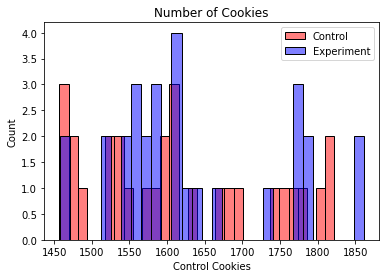

In [137]:
sns.histplot(df_ratios['Control Cookies'], bins=30, color='r', alpha=0.5)
sns.histplot(df_ratios['Experiment Cookies'], bins=30, color='b', alpha=0.5)
plt.legend(labels = ['Control', 'Experiment'])
plt.title("Number of Cookies")
plt.show()

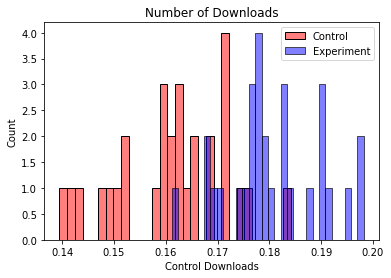

In [138]:
sns.histplot(df_ratios['Control Downloads'], bins=30, color='r', alpha=0.5)
sns.histplot(df_ratios['Experiment Downloads'], bins=30, color='b', alpha=0.5)
plt.legend(labels = ['Control', 'Experiment'])
plt.title("Number of Downloads")
plt.show()

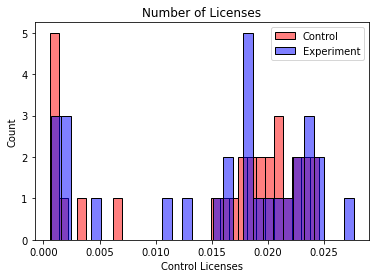

In [139]:
sns.histplot(df_ratios['Control Licenses'], bins=30, color='r', alpha=0.5)
sns.histplot(df_ratios['Experiment Licenses'], bins=30, color='b', alpha=0.5)
plt.legend(labels = ['Control', 'Experiment'])
plt.title("Number of Licenses")
plt.show()

### Invariant Metric: Cookies

In [140]:
feature_analyze = 'Cookies'
subset1 = df_ratios['Control' + ' ' + feature_analyze]
subset2 = df_ratios['Experiment' + ' ' + feature_analyze]
(t_stat, p_value, m1, m2) = t_test(subset1, subset2)

In [141]:
# The number of cookies seems to be invariant for each group
print(f"t_stat = {t_stat}, p_value = {p_value}, m1 = {m1}, m2 = {m2}")

t_stat = -0.5667703149522242, p_value = 0.5731350217922668, m1 = 1615.551724137931, m2 = 1632.6206896551723


### Evaluation Metric: Downloads

In [143]:
feature_analyze = 'Downloads'
n1 = df['Control' + ' ' + 'Cookies'].sum()
n2 = df['Experiment' + ' ' + 'Cookies'].sum()
p1 = df['Control' + ' ' + feature_analyze].sum() / n1
p2 = df['Experiment' + ' ' + feature_analyze].sum() / n2
(z_stat, p_value, p1, p2) = z_test(p1, n1, p2, n2)

In [144]:
# Significant difference
print(f"z_stat = {z_stat}, p_value = {p_value}, p1 = {p1}, p2 = {p2}")

z_stat = -7.870833726066236, p_value = 3.5228559273456157e-15, p1 = 0.16123455209067042, p2 = 0.180543234908968


### Evaluation Metric: Licenses

In [147]:
feature_analyze = 'Licenses'
n1 = df['Control' + ' ' + 'Cookies'].sum()
n2 = df['Experiment' + ' ' + 'Cookies'].sum()
p1 = df['Control' + ' ' + feature_analyze].sum() / n1
p2 = df['Experiment' + ' ' + feature_analyze].sum() / n2
(z_stat, p_value, p1, p2) = z_test(p1, n1, p2, n2)

In [148]:
# No difference!
print(f"z_stat = {z_stat}, p_value = {p_value}, p1 = {p1}, p2 = {p2}")

z_stat = -0.3827453070441281, p_value = 0.7019086175871928, p1 = 0.01515442573264178, p2 = 0.015460651374984159
